In [3]:
import pandas as pd
import numpy as np
import joblib
import os
import gc

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# # Load
# input_file = "combined_data.csv"
# output_file = "train_data_200k.csv"
# df = pd.read_csv(input_file, nrows=200000)
# df.to_csv(output_file, index=False)

In [5]:
TIME_STEPS = 10
BATCH = 16
EPOCHS = 20
MAX_SEQ = 20000   # optional cap để tiết kiệm RAM
FEATURE_COLS = ['tempC','accX','accY','accZ','gyroX','gyroY','gyroZ','angleX','angleY','angleZ','hr']

In [6]:
df = pd.read_csv("train_data_200k.csv")
df.head()

,time,tempC,accX,accY,accZ,gyroX,gyroY,gyroZ,angleX,angleY,angleZ,hr
0,2021-01-01 11:22:48.305804,33.56,1.004385,-0.693700,-0.366474,1.154780,0.162031,-1.012268,0.000000,0.000000,0.000000,106.382999
1,2021-01-01 11:22:48.307804,33.56,1.004934,-0.696874,-0.370197,1.149587,0.175879,-1.005211,-0.637444,-0.066491,0.576309,106.382999
2,2021-01-01 11:22:48.309804,33.56,1.005605,-0.698339,-0.381550,1.137070,0.198783,-0.985370,-1.268609,-0.139815,1.141699,106.382999
3,2021-01-01 11:22:48.311804,33.56,1.005605,-0.698339,-0.381550,1.137070,0.198783,-0.985370,-1.900552,-0.206855,1.707557,106.382999
4,2021-01-01 11:22:48.313804,33.56,1.007192,-0.700902,-0.383748,1.129213,0.206506,-0.972453,-2.528838,-0.272241,2.266426,106.382999


In [7]:
# Chuẩn hoá dữ liệu
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[FEATURE_COLS].values)
joblib.dump(scaler, "scaler.pkl")

mins = scaler.data_min_
maxs = scaler.data_max_
np.save("feature_mins.npy", np.array(mins, dtype=np.float32))
np.save("feature_maxs.npy", np.array(maxs, dtype=np.float32))

In [8]:
def create_sequences(arr, time_steps=TIME_STEPS):
    X = []
    for i in range(len(arr) - time_steps + 1):
        X.append(arr[i:i+time_steps])
    return np.array(X)

X = create_sequences(data_scaled, TIME_STEPS)
if len(X) > MAX_SEQ:
    X = X[:MAX_SEQ]
print("Sequences shape:", X.shape)  # (N_seq, 10, 11)

Sequences shape: (20000, 10, 11)


In [9]:
# Tạo model
n_features = X.shape[2]
model = Sequential([
    Input(shape=(TIME_STEPS, n_features)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(TIME_STEPS * n_features, activation='sigmoid'),  # vì dùng MinMaxScaler -> in [0,1]
    Reshape((TIME_STEPS, n_features))
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 110)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         7,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 110)            │         7,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 11)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,446 (72.05 KB)

 Trainable params: 18,446 (72.05 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Huấn luyện
early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
history = model.fit(X, 
                    X, 
                    batch_size=BATCH, 
                    epochs=EPOCHS, 
                    shuffle=True,
                    callbacks=[early_stop], 
                    verbose=1)



Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0059
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0014
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0011
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.3994e-04
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.4777e-04
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.8641e-04
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.4341e-04
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.0655e-04
Epoch 9/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.8932e-04
Epoch 10/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.7053e-04
Epoch 11/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.5679e-04
Epoch 12/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.4278e-04
Epoch 13/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.2985e-04
Epoch 14/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - lo

In [11]:
X_pred = model.predict(X, verbose=0)
mse = np.mean(np.power(X - X_pred, 2), axis=(1,2))  # MSE per sequence
thr95 = np.percentile(mse, 95)
thr99 = np.percentile(mse, 99)
print("Threshold 95pct:", thr95, "  99pct:", thr99)


Threshold 95pct: 0.0008969453198172658   99pct: 0.0035065565481153587


Text(0, 0.5, 'MSE')

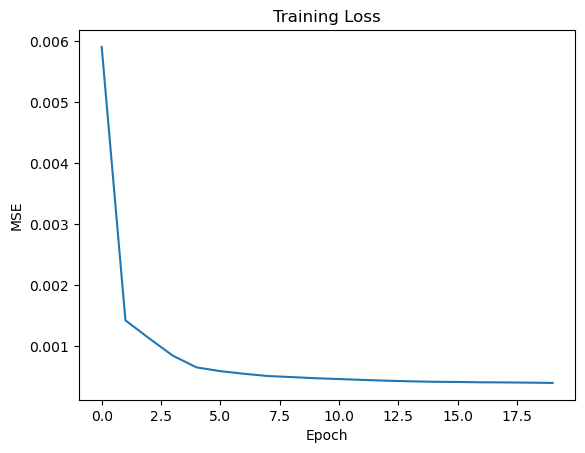

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')

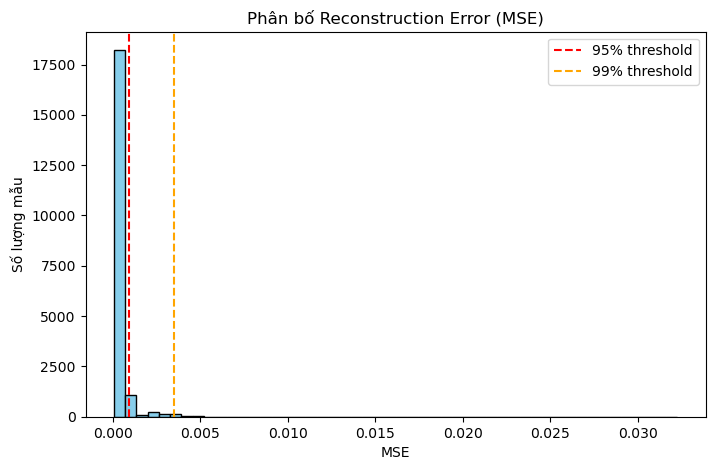

In [13]:
plt.figure(figsize=(8,5))
plt.hist(mse, bins=50, color='skyblue', edgecolor='black')
plt.axvline(np.percentile(mse, 95), color='red', linestyle='--', label='95% threshold')
plt.axvline(np.percentile(mse, 99), color='orange', linestyle='--', label='99% threshold')
plt.title('Phân bố Reconstruction Error (MSE)')
plt.xlabel('MSE')
plt.ylabel('Số lượng mẫu')
plt.legend()
plt.show()


In [14]:
np.save("mse_threshold_95.npy", np.array([thr95], dtype=np.float32))
np.save("mse_threshold_99.npy", np.array([thr99], dtype=np.float32))
model.save("dense_autoencoder_model.h5")


In [15]:
# Convert sang TFLite int8

import tensorflow as tf

# Representative dataset
def representative_data_gen():
    step = max(1, len(X)//150)
    for i in range(0, len(X), step):
        sample = X[i:i+1].astype(np.float32)
        yield [sample]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quant_model = converter.convert()
with open("dense_autoencoder_esp32_int8.tflite","wb") as f:
    f.write(tflite_quant_model)

print("Saved int8 quantized model (KB):", os.path.getsize("dense_autoencoder_esp32_int8.tflite")/1024)
gc.collect()


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmphx3189cf\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmphx3189cf\assets


Saved artifact at 'C:\Users\ASUS\AppData\Local\Temp\tmphx3189cf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 11), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10, 11), dtype=tf.float32, name=None)
Captures:
  2242185018256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2242185019216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2242185018640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2242270381072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2242270381456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2242270381840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2242270380304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2242270380688: TensorSpec(shape=(), dtype=tf.resource, name=None)


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved int8 quantized model (KB): 29.6328125


8219

In [16]:
# Load mô hình TFLite int8
interpreter = tf.lite.Interpreter(model_path="dense_autoencoder_esp32_int8.tflite")
interpreter.allocate_tensors()

# Lấy thông tin input/output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# In ra để kiểm tra
print("Input details:", input_details)
print("Output details:", output_details)

# Lấy scale và zero-point
input_scale, input_zero_point = input_details[0]['quantization']
output_scale, output_zero_point = output_details[0]['quantization']

# Chọn 1 mẫu duy nhất để test (1, 10, 11)
test_sample = X[0:1].astype(np.float32)  # Giữ 3D (1, TIME_STEPS, n_features)

# Chạy model gốc float32
float_pred = model.predict(test_sample)

# Chuẩn bị input int8 cho TFLite
test_input_int8 = test_sample / input_scale + input_zero_point
test_input_int8 = np.clip(test_input_int8, -128, 127).astype(np.int8)

# Set input cho interpreter
interpreter.set_tensor(input_details[0]['index'], test_input_int8)
interpreter.invoke()

# Lấy output
tflite_output = interpreter.get_tensor(output_details[0]['index'])

# Quy đổi ngược về float32
tflite_output_float = (tflite_output.astype(np.float32) - output_zero_point) * output_scale

# So sánh kết quả
mse_float = np.mean(np.power(test_sample - float_pred, 2))
mse_tflite = np.mean(np.power(test_sample - tflite_output_float, 2))
diff = abs(mse_tflite - mse_float) / mse_float * 100

print(f"\nMSE gốc (float32): {mse_float:.6f}")
print(f"MSE int8 (TFLite): {mse_tflite:.6f}")
print(f"Sai khác: {diff:.2f}%")

if diff < 10:
    print("Kết quả gần như giống nhau → an toàn để nạp ESP32.")
elif diff < 25:
    print("Sai khác trung bình → vẫn dùng được, nhưng nên kiểm tra lại dữ liệu đại diện.")
else:
    print("Model sau lượng tử hoá sai khác nhiều → nên cải thiện representative dataset.")

gc.collect()

Input details: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([ 1, 10, 11]), 'shape_signature': array([-1, 10, 11]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003916582092642784, -128), 'quantization_parameters': {'scales': array([0.00391658], dtype=float32), 'zero_points': array([-128]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 26, 'shape': array([ 1, 10, 11]), 'shape_signature': array([-1, 10, 11]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

MSE gốc (float32): 0.000192
MSE int8 (TFLite): 0.000243
Sai khác: 26.50%
Model sau lượng tử hoá sai khác nhiều → nên cải thiện representative dataset.


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


329

In [17]:
input_bytes = np.prod(input_details[0]['shape'])
arena_estimate = input_bytes * 8
print("Ước tính Tensor Arena:", arena_estimate / 1024, "KB")

Ước tính Tensor Arena: 0.859375 KB


In [18]:
with open("dense_autoencoder_esp32_int8.tflite", "rb") as f:
    data = f.read()

# Tạo nội dung file .h
hex_array = ', '.join(f'0x{b:02x}' for b in data)
header = f"""\
#ifndef DENSE_AUTOENCODER_ESP32_INT8_H
#define DENSE_AUTOENCODER_ESP32_INT8_H

const unsigned char dense_autoencoder_esp32_int8_tflite[] = {{
{hex_array}
}};

const int dense_autoencoder_esp32_int8_tflite_len = {len(data)};

#endif  // DENSE_AUTOENCODER_ESP32_INT8_H
"""

# Ghi ra file .h
with open("dense_autoencoder_esp32_int8.h", "w") as f:
    f.write(header)

print("Đã tạo file dense_autoencoder_esp32_int8.h")

Đã tạo file dense_autoencoder_esp32_int8.h
